# Shockley-Queisser Limit Calculator
Or more accurately the _detailed balance limit_ calculator

Based on the Mathematica script by Steve Byrnes. Original pdf explaning the script available here: http://sjbyrnes.com/sq.pdf, do check it out, if only for the correct pronunciation of 'Queisser'. 

From Steve's document:

> The Schockley-Queisser (SQ) limit is a famous limit on the maximal possible efficiency of solar cells, limited only by fundamental physics. It applies to most solar cell designs in the world, except for "tandem solar cells" and some additional obscure exceptions (discussed at the end of the document) [Check out the original pdf for this info]. The most important parameter in the SQ model is the bandgap of the semiconductor: If the gap is right, the efficiency can be up to 34%, if the gap is way off, the efficiency limit may be much smaller.

The efficiency predicted by the SQ limit **applies only to the solar spectrum**. This notebook first recreates the SQ limit calculation to verify the method, and then applies it to some artificial light sources. 

In [1]:
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
import os

In [2]:
%matplotlib inline

In [3]:
# Loading data from text files
# You may have to modify the next line if running the notebook locally
module_dir = os.path.dirname(os.path.abspath('.\\Jupyter\\')) + os.sep

# the ASTMG173.csv file holds the standard AM1.5 solar spectrum
# You can find the original at rredc.nrel.gov/solar/spectra/am1.5
spectrum = np.loadtxt(module_dir + '\\Spectra\\'+ 'ASTMG173.csv', delimiter=',', skiprows=1)

In [314]:
# Just some constants for the upcoming math
c = constants.value('speed of light in vacuum')
h = constants.value('Planck constant in eV s')
e = constants.value('elementary charge')
k = constants.value('Boltzmann constant in eV/K')

pi = 3.1415

# Globals
Tcell = 300  # Kelvin
# Energy Gap
# The energy gap enetered here will be highlighted on upcoming plots. 
# Default is set to silicon bandgap 1.1eV
Egap = 1.1  #electron volts
egap = 1.1  #electron volts
# Silicon = 1.1eV

In [371]:
E_min = 0.3
E_max = 10
E_step = 0.01

##Why are numbers not correct?

#think the 'h' constant in the 'a' below shold be divided out when converting planck law to eV but can't figure it out. Numbers seem close when calcuating the irradiance on the earth with an approximate solid angle

def solid_angle (r_e, d_sun):
    return 4*(pi)*((pi*r_e**2)/(4*pi*d_sun**2))


def planck(T,E_min,E_max ,E_step ):

    E_bb = np.arange(E_min, E_max,E_step) 
    E_bb = np.flip(E_bb,0)
    print(k)
    a = (2*h*((E_bb/h)**3))/(c**2)
    b = 1/( np.exp((E_bb)/(k*T)) -1 )
    intensity = a*b
    
    sa = solid_angle(6e6,150e9)
    print(sa)
    
    intensity = intensity*sa #solid angle of earth
    
    spectra = np.transpose(np.stack((E_bb,intensity)))
    return spectra


# A helper function that will do the job for us
def convert_spectrum(spectrum):
    """
    Spectrum input:
        y: Irradiance (W/m2/eV)
        x: Photon Energy (eV)
    Converted otput:
        y: Number of photons (Np/m2/s/dE)
        x: Energy (eV)
    """
    converted = np.copy(spectrum)

    converted[:, 1] = converted[:, 1]/converted[:,0] * 1/e

    return converted

#BB_300K = planck(300,v_min,v_max ,v_step)
BB_5500K = planck(5000,E_min,E_max ,E_step)

BB_5500K_ph = convert_spectrum(BB_5500K)

integrate = -np.trapz(BB_5500K[:,1],BB_5500K[:,0] )
#BB_5500K.max()
#((0.1**3))/((h*c)**2)
#spectrum[:,0]

integrate 

8.6173303e-05
5.026400000000001e-09


1444.2803128195442

Total spectrum irriadiance:  1000.4707036093448 W/m^2
2002


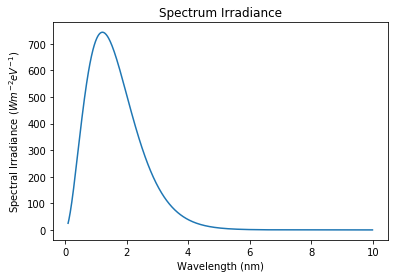

In [366]:
plt.plot(BB_5500K[:,0],BB_5500K[:,1])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Irradiance ($Wm^{-2}eV^{-1}$)')
plt.title('Spectrum Irradiance')
#original_irradiance = np.trapz(spectrum[:, 1], spectrum[:, 0])
print('Total spectrum irriadiance: ', original_irradiance, 'W/m^2')
print(len(spectrum))

Total spectrum irriadiance:  1000.4707036093448 W/m^2
2002


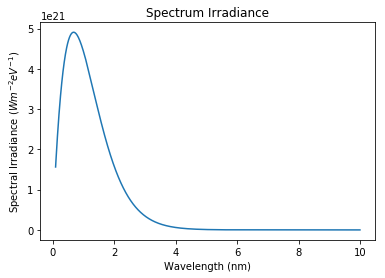

In [367]:


plt.plot(BB_5500K_ph[:,0],BB_5500K_ph[:,1] )
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Irradiance ($Wm^{-2}eV^{-1}$)')
plt.title('Spectrum Irradiance')
#original_irradiance = np.trapz(spectrum[:, 1], spectrum[:, 0])
print('Total spectrum irriadiance: ', original_irradiance, 'W/m^2')
print(len(spectrum))

### Photons above bandgap
Only photons which have an energy above the bandgap of the material in question can promote electrons to the conduction band. Let's plot their number as a function of the bandgap.

In [355]:
def photons_above_bandgap(egap, spectrum):
    """Counts number of photons above given bandgap"""
    indexes = np.where(spectrum[:, 0] > egap)
    y = spectrum[indexes, 1][0]
    x = spectrum[indexes, 0][0]
    return np.trapz(y[::-1], x[::-1])


def photons_above_bandgap_plot(spectrum):
    """Plot of photons above bandgap as a function of bandgap"""
    a = np.copy(spectrum)
    for row in a:
        # print row
        row[1] = photons_above_bandgap(row[0], spectrum)
    plt.plot(a[:, 0], a[:, 1])

    p_above_1_1 = photons_above_bandgap(Egap, spectrum)
    plt.plot([Egap], [p_above_1_1], 'ro')
    plt.text(Egap+0.05, p_above_1_1, '{}eV, {:.4}'.format(Egap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('# Photons $m^{-2}s^{-1}$')
    plt.title('Number of above-bandgap \nphotons as a function of bandgap')
    plt.show()

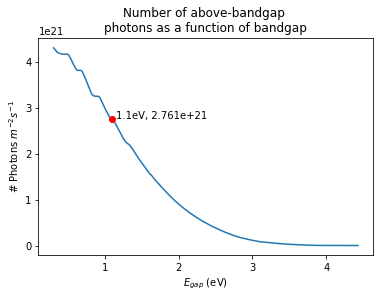

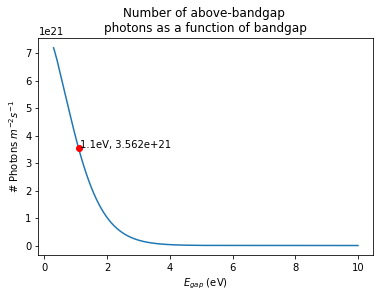

In [356]:


photons_above_bandgap_plot(photon_spectrum)
photons_above_bandgap_plot(BB_5500K_ph)

### Radiative Recombination
From Steve's explanation:

**Recombination rate**
> In the best possible case, the only cause of electron-hole-pair recombination is radiative recombination. Radiative recombination occurs when an electron and hole collide, so it depends on how many electrons and holes there are, or more specifically is depends on the electron and hole QFLs [Quasi-Fermi Level]

** Recombination rate when electron QFL = hole QFL**

> This is the case where electron QFL = hole QFL throughout the semiconductor. An example is the solar cell at zero bias in the dark. Then it’s in thermal equilibrium and its radiation can be calculated by the blackbody formula -- more specifically, assuming it’s a perfect blackbody above the bandgap and white-body below the bandgap. We also assume isotropic radiation from the top surface, and a mirror on the bottom surface.

> Let RR0 be the "Radiative Recombination rate at 0 QFL splitting", (per solar-cell area). By the blackbody formula:

> $RR0 = \frac{2\pi}{c^2h^3} \int_{E_{gap}}^{\infty}{\frac{E^2}{\exp{\frac{E}{kR}-1}}dE}$

In [357]:
def rr0(egap, spectrum):

    const = (2 * np.pi) / (c**2 * h**3)

    E = spectrum[::-1, ]  # in increasing order of bandgap energy
    egap_index = np.where(E[:, 0] >= egap)
    numerator = E[:, 0]**2
    exponential_in = E[:, 0] / (k * Tcell)
    denominator = np.exp(exponential_in) - 1
    integrand = numerator / denominator

    integral = np.trapz(integrand[egap_index], E[egap_index, 0])

    result = const * integral
    return result[0]

Again from Steve:

**Recombination rate when electron QFL and hole QFL are split**

>By kinetic theory, the radiative recombination rate is proportional to the product of electron concentration and hole concentration, p? n. If you move the electron QFL up towards the conduction band by energy E, the electron concentration increases by Exp[- E/kT]. Likewise, if you move the hole QFL down towards the valence band by E, the hole concentration increases by Exp[E/kT]. Either way, pn [is proportional] to Exp[E/kT], where E is the QFL energy splitting.

>In the best possible case, the QFL splitting is equal to the external voltage (in reality, it may be larger than the external voltage). Therefore, the lowest possible radiative recombaniton rate is:

>Recombination rate $= e \times RR0 \times exp{(\frac{eV}{kT})}$


There are some caveats for really small bandgaps <200meV where a more accurate expression is needed so beware. Check out the corresponding section in Steve's document for details. 

In [358]:
def recomb_rate(egap, spectrum, voltage):
    print( 'recomb rate')
    return e * rr0(egap, spectrum) * np.exp(voltage / (k * Tcell))

### J and V versus bandgap
The short circuit current density $J$ and open circuit voltage $V$ for an ideal solar cell.

From Steve: 

> The current is from the electron-hole pairs that are created but which don’t recombine. In the best case, all the solar photons possible are absorbed, while none recombine except radiatively. This gives:

> $ J = e (N_p - RR0 \times e^{\frac{eV}{kT}}-1) $

> where $J$ is the current per unit area, and $V$ is the forward bias on the junction[, and $N_p$ is the number of solar photons above the bandgap]. The "-1" on the right accounts for spontaneous generation of e-h pairs through thermal fluctuations at 300K. I will leave out the "-1" below because $RR0 << N_p$

In [359]:
def current_density(egap, spectrum, voltage):
    # print 'current_density'
    # print photons_above_bandgap(egap, spectrum), 'photons above bandgap'
    # print e * (photons_above_bandgap(egap, spectrum) - rr0(egap, spectrum)), 'photons above bandgap - rr0'
    return e * (photons_above_bandgap(egap, spectrum) - rr0(egap, spectrum) * np.exp(voltage / (k * Tcell)))


def jsc(egap, spectrum):
    # print 'jsc'
    return current_density(egap, spectrum, 0)


def voc(egap, spectrum):
    # print 'voc'
    return (k * Tcell) * np.log(photons_above_bandgap(egap, spectrum) / rr0(egap, spectrum))

In [360]:
# For an ideal solar cell these will be
print('A material with a bandgap of %.2f will have an:' % Egap)
print('Ideal short circuit current: ', jsc(1.1, BB_5500K_ph), 'A/m^2')
print('Ideal open circuit  voltage: ', voc(1.1, BB_5500K_ph), 'V')

A material with a bandgap of 1.10 will have an:
Ideal short circuit current:  570.698908561382 A/m^2
Ideal open circuit  voltage:  0.8640506741956516 V


In [361]:
photon_spectrum

array([[4.42800705e+00, 4.21591819e-03],
       [4.42011399e+00, 1.10220061e-01],
       [4.41224902e+00, 5.12611289e-01],
       ...,
       [3.10737337e-01, 1.90082929e+21],
       [3.10348429e-01, 1.86656258e+21],
       [3.09960493e-01, 1.84499529e+21]])

In [374]:
def ideal_jsc_plot(spectrum):
    """Plot of photons above bandgap as a function of bandgap"""
    a = np.copy(spectrum)
    for row in a:
        # print row
        row[1] = jsc(row[0], spectrum)
    plt.plot(a[:, 0], a[:, 1])
    e_gap = 1.1
    p_above_1_1 = jsc(e_gap, spectrum)
    plt.plot([e_gap], [p_above_1_1], 'ro')
    plt.text(e_gap+0.05, p_above_1_1, '{}eV, {:.4}'.format(e_gap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('$J_{SC}$ $Am^{-2}$')
    plt.title('Ideal short-circuit current')


def ideal_voc_plot(spectrum):
    """Plot of the ideal open circuit voltage as a function of bandgap"""
    a = np.copy(spectrum)
    for row in a[2:]:
        # print row
        row[1] = voc(row[0], spectrum)
    plt.plot(a[:, 0], a[:, 1])
    plt.plot(a[:, 0], a[:, 0])
    e_gap = 1.1
    p_above_1_1 = voc(e_gap, spectrum)
    plt.plot([e_gap], [p_above_1_1], 'ro')
    plt.text(e_gap+0.05, p_above_1_1, '{}eV, {:.4}'.format(e_gap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('$V_{OC}$ (V)')
    plt.xlim((0.5,3.5))
    plt.ylim((0,3.5))
    plt.title('Ideal open-circuit voltage. Straight line is bandgap.')

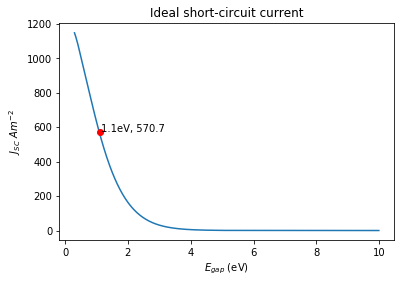

In [372]:
ideal_jsc_plot(BB_5500K_ph)

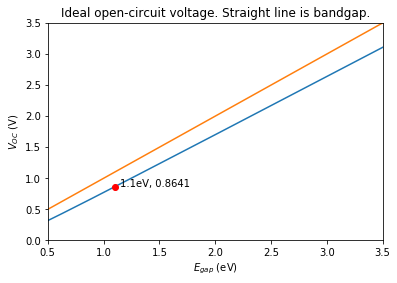

In [375]:
ideal_voc_plot(BB_5500K_ph)

### Maximum efficiency
With a method to find the ideal current and the ideal voltage, we can combine them to find the ideal power.

The efficiency of a solar cell is 

$\eta = \frac{IV}{E_e}$

where $I$ and $V$ are the current and voltage of the solar cell, and $E_e$ is the total irradiance incident on the cell. An IV curve of a solar cell looks like this:

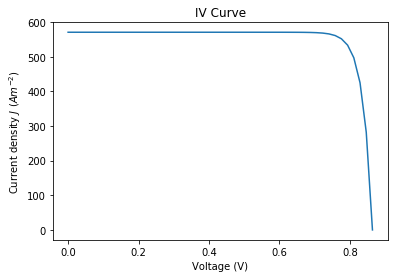

In [377]:
def iv_curve_plot(egap, spectrum, power=False):
    """Plots the ideal IV curve, or the ideal power for a given material"""
    v_open = voc(egap, spectrum)
    v = np.linspace(0, v_open)
    if power:
        p =  v * current_density(egap, spectrum, v)
        plt.xlabel('Voltage (V)')
        plt.ylabel('Power generated ($W$)')
        plt.title('Power Curve')
        plt.plot(v, p)
    else:
        i =  current_density(egap, spectrum, v)
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current density $J$ ($Am^{-2}$)')
        plt.title('IV Curve')
        plt.plot(v, i)
    
iv_curve_plot(Egap, BB_5500K_ph)

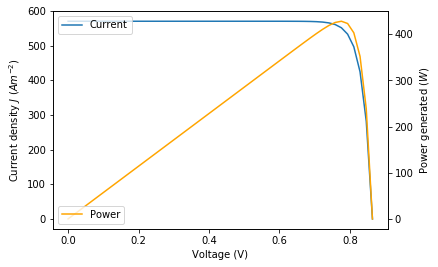

In [379]:
def iv_curve_plot(egap, spectrum, power=False):
    """Plots the ideal IV curve, and the ideal power for a given material"""
    v_open = voc(egap, spectrum)
    v = np.linspace(0, v_open)

    fig, ax1 = plt.subplots()
    p =  v * current_density(egap, spectrum, v)
    i =  current_density(egap, spectrum, v)
    
    ax1.plot(v, i)
    ax1.set_xlabel('Voltage (V)')
    ax1.set_ylabel('Current density $J$ ($Am^{-2}$)')
    ax1.legend(['Current'], loc=2)
    
    ax2 = ax1.twinx()
    ax2.plot(v, p, color='orange')
    ax2.set_ylabel('Power generated ($W$)')
    ax2.legend(['Power'], loc=3)
    return


iv_curve_plot(Egap, BB_5500K_ph)

The product of each point on the $IV$ curve will give the possible generated power. The power plot has a clear peak.

This is important for achieving the highest power generation efficiency. The cell needs to be operated at a specific operating point. Often this point is not the same as the operating point of a load the cell is supplying power to and special circuits are needed to maximise the power harvested from a solar cell.

To obtain the efficiency we need to find the peak power point on the power curve. Here's some helper functions to do that, and to calculate the efficiency $\eta$:

In [380]:
def v_at_mpp(egap, spectrum):
    v_open = voc(egap, spectrum)
    # print v_open
    v = np.linspace(0, v_open)
    index = np.where(v * current_density(egap, spectrum, v)==max(v * current_density(egap, spectrum, v)))
    return v[index][0]


def j_at_mpp(egap, spectrum):
    return max_power(egap, spectrum) / v_at_mpp(egap, spectrum)


def max_power(egap, spectrum):
    v_open = voc(egap, spectrum)
    # print v_open
    v = np.linspace(0, v_open)
    index = np.where(v * current_density(egap, spectrum, v)==max(v * current_density(egap, spectrum, v)))
    return max(v * current_density(egap, spectrum, v))


def max_eff(egap, spectrum):
    irradiance =  np.trapz(spectrum[::-1, 1] * e * spectrum[::-1, 0], spectrum[::-1, 0])
    # print photons_above_bandgap(egap, spectrum) * e
    return max_power(egap, spectrum) / irradiance

In [384]:
print('For a cell with bandgap %.2f eV' % Egap)
print('Ideal efficiency is {:.4}%'.format(max_eff(Egap, BB_5500K_ph)*100))

For a cell with bandgap 1.10 eV
Ideal efficiency is 29.65%


To find the famous SQ limit curve, we need to maximise the ideal generated power over the bandgap energies. 

In [385]:
def sq_limit_plot(spectrum):
    # Plot the famous SQ limit
    a = np.copy(spectrum)
    # Not for whole array hack to remove divide by 0 errors
    for row in a[2:]:
        # print row
        row[1] = max_eff(row[0], spectrum)
    # Not plotting whole array becase some bad values happen
    plt.plot(a[2:, 0], a[2:, 1])
    e_gap = Egap
    p_above_1_1 = max_eff(e_gap, spectrum)
    plt.plot([e_gap], [p_above_1_1], 'ro')
    plt.text(e_gap+0.05, p_above_1_1, '{}eV, {:.4}'.format(e_gap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('Max efficiency')
    plt.title('SQ Limit')

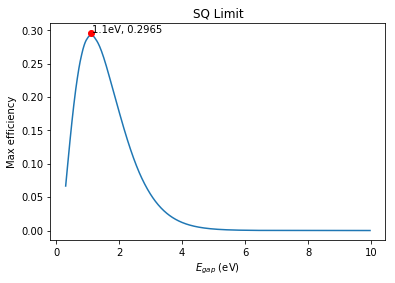

In [386]:
sq_limit_plot(BB_5500K_ph)

## Quantifying losses
So isn't all the energy available? One reason already explained is that photons below the bandgap energy cannot generate electron-hole pairs. This does not explain all of the power. 

From Steve:

>We split the incoming light power into five parts: 

>(A) Power converted into useful electricity; 

>(B) Power of below-bandgap photons, which is wasted power because these photons are not absorbed; 

>(C) Excess photon energy beyond the bandgap, which is wasted because the electron and hole just immediately relax to the band edges. For example, for a 1eV-bandgap semiconductor, a 3eV photon creates the same electron-hole pair as a 1.01eV photon. All the 2eV of extra energy carried by a 3eV photon in that case is wasted. 

>(D) Power lost due to electron-hole recombination at the max-power-point, which is wasted as heat; 

>(E) Power lost because the voltage of the cell at the max-power-point is less than the bandgap

Below are functions which calculate all these:

In [387]:
def excess_beyond_gap(egap, spectrum):
    """Loss due to energy beyond bandgap; lost as heat"""
    # find egap index
    indexes = np.where(spectrum[:, 0] > egap)
    y = spectrum[indexes, 1][0]
    x = spectrum[indexes, 0][0]
    return np.trapz(y[::-1] * (x[::-1] - egap), x[::-1])


def energy_below_gap(egap, spectrum):
    """Energy of photons below the bandgap"""
    # find egap index
    indexes = np.where(spectrum[:, 0] < egap)
    y = spectrum[indexes, 1][0]
    x = spectrum[indexes, 0][0]
    return np.trapz(y[::-1] * x[::-1], x[::-1])


def mpp_recombination(egap, spectrum):
    """Loss due to recombination at the maximum power point"""
    return photons_above_bandgap(egap, spectrum) - j_at_mpp(egap, spectrum) / e


def mpp_v_less_than_gap(egap, spectrum):
    return j_at_mpp(egap, spectrum) * (egap - v_at_mpp(egap, spectrum))


def loss(egap, spectrum):
    """Returns a list with a breakdown of where the energy is lost"""
    solar_constant = np.trapz(spectrum[::-1, 1] * e * spectrum[::-1, 0], spectrum[::-1, 0])
    useful_electricity = max_eff(egap, spectrum)
    below_gap = energy_below_gap(egap, spectrum) * e / solar_constant
    beyond_gap = excess_beyond_gap(egap, spectrum) * e / solar_constant
    recomb = mpp_recombination(egap, spectrum) * e / solar_constant
    v_less = mpp_v_less_than_gap(egap, spectrum) / solar_constant
    return [useful_electricity, below_gap, beyond_gap, recomb, v_less]

In [389]:
def print_losses(egap, spectrum):
    """Print the breakdown of loss() nicely"""
    losses = loss(egap, spectrum)
    print('Useful electricity: \t\t\t{:.4}%'.format(losses[0]*100))
    print('Below bandgap losses: \t\t\t{:.4}%'.format(losses[1]*100))
    print('Excess beyond gaplosses:\t\t{:.4}%'.format(losses[2]*100))
    print('Recombination losses: \t\t\t{:.4}%'.format(losses[3]*100))
    print('MPP Voltage less than gap losses: \t{:.4}%'.format(losses[4]*100))
    print('Total should be close to 100%: \t\t{:.4}%'.format(sum(losses)*100))
    
print_losses(Egap, BB_5500K_ph)

Useful electricity: 			29.65%
Below bandgap losses: 			28.09%
Excess beyond gaplosses:		27.93%
Recombination losses: 			1.305%
MPP Voltage less than gap losses: 	12.38%
Total should be close to 100%: 		99.36%


Making a plot out of the losses. This function takes a while to evaluate.

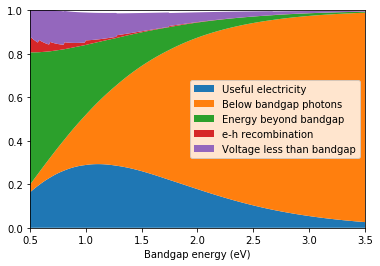

In [391]:
def loss_plot(spectrum):
    gaps = spectrum[2:,0]

    a_arr = np.empty_like(gaps)
    b_arr = np.empty_like(gaps)
    c_arr = np.empty_like(gaps)
    d_arr = np.empty_like(gaps)
    e_arr = np.empty_like(gaps)
    
    for index, gap in enumerate(gaps):
        q,w,e,r,t = loss(gap, spectrum)
        a_arr[index] = q
        b_arr[index] = w
        c_arr[index] = e
        d_arr[index] = r
        e_arr[index] = t
    
    plt.xlabel('Bandgap energy (eV)')
    plt.stackplot(gaps, [a_arr,b_arr,c_arr,d_arr,e_arr])
    plt.xlim(0.5,3.5)
    plt.ylim(0,1)
    labels = ['Useful electricity', 
          'Below bandgap photons', 
          'Energy beyond bandgap', 
          'e-h recombination', 
          'Voltage less than bandgap']
#     plt.legend(labels, loc='upper left', bbox_to_anchor=(1,1))
    plt.legend(labels, loc=7)
    
loss_plot(BB_5500K_ph)

The plot is only really valid where the sum is close to 1. For low bandgap energies <200meV the total losses add up to more than 1 because of the approximation used previusly.

C:\Users\aspit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


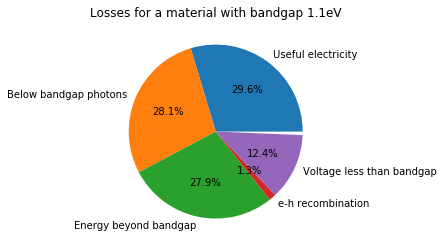

In [392]:
def plot_pie_breakdown(spectrum):
    losses_11eV = loss(Egap, spectrum)
    labels = ['Useful electricity', 
              'Below bandgap photons', 
              'Energy beyond bandgap', 
              'e-h recombination', 
              'Voltage less than bandgap']
    plt.pie(losses_11eV, labels=labels, autopct='%.1f%%')
    plt.title('Losses for a material with bandgap {}eV'.format(Egap))
    plt.axes().set_aspect('equal')
    plt.show()
    
plot_pie_breakdown(BB_5500K_ph)

# Exploring effect of irradiance level on the efficiency
Whether under the same spectral distribution but lower total irradiance the efficiency is different.

Let's do this for sunlight and scale it to a few different total irradiances. We already have the standard reference case of 1000$Wm^{-2}$, so let's try 100, 10, and 1. First we need a general method of scaling the spectrum to whatever total power we want.

In [393]:
def normalise_power(spectrum):
    result = np.copy(spectrum)
    power = np.trapz(result[:,1], result[:,0])
    result[:,1] /= power
    return result

def denormalise_power(spectrum, power):
    result = np.copy(spectrum)
    result[:,1] *= power
    return result

In [399]:
spectrum_100W = denormalise_power(normalise_power(BB_5500K), 100)
spectrum_10W = denormalise_power(normalise_power(BB_5500K), 10)
spectrum_1W = denormalise_power(normalise_power(BB_5500K), 1)
photon_spectrum_100W = convert_spectrum(spectrum_100W)
photon_spectrum_10W = convert_spectrum(spectrum_10W)
photon_spectrum_1W = convert_spectrum(spectrum_1W)

In [400]:
print('1000W')
print_losses(1.1, photon_spectrum)
print('\n100W')
print_losses(1.1, photon_spectrum_100W)
print('\n10W')
print_losses(1.1, photon_spectrum_10W)
print('\n1W')
print_losses(1.1, photon_spectrum_1W)

x = [1, 10, 100, 1000]
a_arr = np.empty_like(x)
b_arr = np.empty_like(x)
c_arr = np.empty_like(x)
d_arr = np.empty_like(x)
e_arr = np.empty_like(x)
w1 = loss(1.1, photon_spectrum_1W)
w2 = loss(1.1, photon_spectrum_10W)
w3 = loss(1.1, photon_spectrum_100W)
w4 = loss(1.1, photon_spectrum)

a_arr = [w1[0], w2[0], w3[0], w4[0]]
b_arr = [w1[1], w2[1], w3[1], w4[1]]
c_arr = [w1[2], w2[2], w3[2], w4[2]]
d_arr = [w1[3], w2[3], w3[3], w4[3]]
e_arr = [w1[4], w2[4], w3[4], w4[4]]

plt.stackplot(x, [a_arr, b_arr, c_arr, d_arr, e_arr])
plt.semilogx()
plt.xlabel('Total Irradiance ($Wm^{-2}$)')
plt.title('Losses against total power.\nUseful electricity in blue.')
plt.show()

1000W
Useful electricity: 			32.91%
Below bandgap losses: 			18.77%
Excess beyond gaplosses:		32.59%
Recombination losses: 			1.496%
MPP Voltage less than gap losses: 	14.08%
Total should be close to 100%: 		99.84%

100W


C:\Users\aspit\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


IndexError: index 0 is out of bounds for axis 0 with size 0

Interestingly, the peak theoretical efficiency changes with the total irradiance on the material. At lower irradiances the cell operates at a voltage that is further away from the bandgap voltage, so that component of the loss increases. 